# Impact Aware Embeddings
1. loading textual and price datasets
2. labeling the price dataset and merging it with the textual dataset
3. evaluating the base model on the labels
4. finetuning the embedding model on labelings to make it impact-aware

In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate -U

# Restart Session
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, AdamW, TrainerCallback
from tqdm.notebook import tqdm  # Use notebook version of tqdm for better compatibility with Jupyter
from datetime import timedelta
import plotly.graph_objects as go
from datasets import Dataset
from torch.utils.data import DataLoader, Dataset as torchDS
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from scipy.special import softmax
import torch

## Sys and MLFlow Usages

In [ ]:
# internal imports
import sys
import os
current_working_directory = os.getcwd()
sys.path.append(os.path.dirname(current_working_directory))
from src.util import *

In [ ]:
# setting mlflow parameters
mlflow.set_tracking_uri(uri="https://mlflow.finbright.org/")
mlflow.set_experiment("base_tbl_1000")

<Experiment: artifact_location='/mlruns/1', creation_time=1712675940440, experiment_id='1', last_update_time=1712675940440, lifecycle_stage='active', name='base_tbl_1000', tags={}>

## reading textual and price datasets

In [3]:
# reading embedded textual dataset which should contain (date, text, embeddings)
# TODO: generate the dataset if it doesn't exist
text_db_path = '/content/drive/MyDrive/combined_tweets_2020_labeled.csv'

text_df = pd.read_csv(text_db_path, usecols=["date", "text_split"])
text_df.rename(columns={"text_split": "text"}, inplace=True)
text_df.set_index('date', inplace=True)
text_df.index = pd.to_datetime(text_df.index)

In [4]:
# reading price data
price_db_path = '/content/drive/MyDrive/daily-2020.csv'

price_df = pd.read_csv(price_db_path, usecols=["timestamp", "close", "open", "high", "low", "volume"])
price_df.set_index('timestamp', inplace=True)
price_df.index = pd.to_datetime(price_df.index, unit='s')

In [5]:
text_df.shape

(64310, 1)

In [6]:
text_df

,text
date,
2020-01-01,is the year of bitcoin bitcoin is up in decade...
2020-01-01,activity and bases when can print they need go...
2020-01-01,address related to his announcement why they b...
2020-01-01,xrp btc btc price action is similar to bitcoin...
2020-01-01,about cryptocurrency and will be the beginning...
...,...
2020-12-31,like few ago it great way to talk about bitcoi...
2020-12-31,to to review the year in crypto take look at w...
2020-12-31,mas dinheiro bitcoin em coin green nature love...


In [7]:
price_df.shape

(366, 5)

In [8]:
price_df

,open,high,low,close,volume
timestamp,,,,,
2020-01-01,7189.43,7260.43,7170.15,7197.57,56801.329
2020-01-02,7197.57,7209.59,6922.00,6962.04,115295.677
2020-01-03,6962.34,7407.28,6863.44,7341.72,208493.458
2020-01-04,7341.60,7400.00,7269.21,7350.71,92586.033
2020-01-05,7350.54,7495.00,7303.00,7354.36,117765.972
...,...,...,...,...,...
2020-12-27,26508.84,28459.84,25850.00,26305.64,540264.148
2020-12-28,26301.76,27538.82,26117.10,27102.66,267563.468
2020-12-29,27101.45,27441.73,25913.01,27402.83,260759.449


In [9]:
# Shift the Bitcoin price data by one day forward
price_df_shifted = price_df.shift(-1)
price_df_shifted

,open,high,low,close,volume
timestamp,,,,,
2020-01-01,7197.57,7209.59,6922.00,6962.04,115295.677
2020-01-02,6962.34,7407.28,6863.44,7341.72,208493.458
2020-01-03,7341.60,7400.00,7269.21,7350.71,92586.033
2020-01-04,7350.54,7495.00,7303.00,7354.36,117765.972
2020-01-05,7354.36,7808.65,7345.00,7757.39,168150.317
...,...,...,...,...,...
2020-12-27,26301.76,27538.82,26117.10,27102.66,267563.468
2020-12-28,27101.45,27441.73,25913.01,27402.83,260759.449
2020-12-29,27402.83,29063.72,27401.00,28906.99,374737.655


### labeling the price dataset and merging with textual dataset

In [10]:
def triple_barrier_labeling(sdf, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier_timedelta=timedelta(days=3)):
    df = sdf.copy()
    # Define your barriers
    df['upper_barrier'] = df['close'] + df['close'].rolling(volatility_period).std() * upper_barrier_factor
    df['lower_barrier'] = df['close'] - df['close'].rolling(volatility_period).std() * lower_barrier_factor
    df['vertical_barrier'] = df.index + vertical_barrier_timedelta

    # Label the observations
    df['label'] = np.where(df['high'].shift(-1) > df['upper_barrier'], 2,
                           np.where(df['low'].shift(-1) < df['lower_barrier'], 0, 1))

    return df

In [11]:
tbl = triple_barrier_labeling(price_df_shifted)

In [12]:
tbl.iloc[0:40]

,open,high,low,close,volume,upper_barrier,lower_barrier,vertical_barrier,label
timestamp,,,,,,,,,
2020-01-01,7197.57,7209.59,6922.00,6962.04,115295.677,NaN,NaN,2020-01-04,1
2020-01-02,6962.34,7407.28,6863.44,7341.72,208493.458,NaN,NaN,2020-01-05,1
2020-01-03,7341.60,7400.00,7269.21,7350.71,92586.033,NaN,NaN,2020-01-06,1
2020-01-04,7350.54,7495.00,7303.00,7354.36,117765.972,NaN,NaN,2020-01-07,1
2020-01-05,7354.36,7808.65,7345.00,7757.39,168150.317,NaN,NaN,2020-01-08,1
2020-01-06,7757.74,8215.33,7733.00,8152.49,280809.162,NaN,NaN,2020-01-09,1
2020-01-07,8150.90,8468.42,7870.11,8059.84,321225.114,8493.938672,7625.741328,2020-01-10,1
2020-01-08,8059.77,8060.00,7750.01,7818.59,187263.143,8165.197988,7471.982012,2020-01-11,2
2020-01-09,7817.91,8210.62,7670.00,8207.09,253783.948,8562.679646,7851.500354,2020-01-12,1


In [13]:
plot_df = tbl.iloc[0:40]
# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(x=tbl.index,
                                     open=plot_df['open'],
                                     high=plot_df['high'],
                                     low=plot_df['low'],
                                     close=plot_df['close'],
                                     hovertext=['Open: {}<br>High: {}<br>Low: {}<br>Close: {}'.format(o, h, l, c) for o, h, l, c in zip(plot_df['open'], plot_df['high'], plot_df['low'], plot_df['close'])],
                                     hoverinfo='text')])

# Add the labels to the plot as a scatter plot overlay
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['close'], mode='markers',
                         marker=dict(color=plot_df['label'].map({2: 'green', 0: 'red', 1: 'blue'}))))

# Add the upper and lower barriers to the plot
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['upper_barrier'], name='Upper Barrier', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['lower_barrier'], name='Lower Barrier', line=dict(color='orange')))

fig.show()
del(plot_df)

In [14]:
labeled_df = text_df.merge(tbl[['label']], left_index=True, right_index=True, how='left')

In [15]:
labeled_df

,text,label
2020-01-01,is the year of bitcoin bitcoin is up in decade...,1
2020-01-01,activity and bases when can print they need go...,1
2020-01-01,address related to his announcement why they b...,1
2020-01-01,xrp btc btc price action is similar to bitcoin...,1
2020-01-01,about cryptocurrency and will be the beginning...,1
...,...,...
2020-12-31,like few ago it great way to talk about bitcoi...,1
2020-12-31,to to review the year in crypto take look at w...,1
2020-12-31,mas dinheiro bitcoin em coin green nature love...,1
2020-12-31,they re not the best of us it not so much abou...,1


In [58]:
labeled_df.label.value_counts()

label
1    29703
2    19866
0    14741
Name: count, dtype: int64

In [16]:
# Drop rows with NaN labels (corresponding to the last day)
labeled_df = labeled_df.dropna()

In [40]:
# Split the dataset into training and testing subsets with stratification
train_df, test_df = train_test_split(labeled_df, test_size=0.2, random_state=42, stratify=labeled_df['label'])
train_df

,text,label
2020-09-18,good as or better than the roadster into space...,0
2020-07-18,and the stickers are give set of these to one ...,0
2020-03-08,btc panic until this price level panic until t...,1
2020-10-17,bitcoin exposure be going to bed without spot ...,2
2020-03-23,and first en al de bitcoin en para days btc bi...,1
...,...,...
2020-11-04,crypto eth giveaway the interest out by bitcoi...,1
2020-01-24,law wonder bet this person could fight this an...,2
2020-01-25,settlement from racial discrimination lawsuit ...,2
2020-06-19,this site and fresh go after bitcoin soon bitc...,0


In [41]:
# Create Dataset objects from the split dataframes
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

### evaluating the base model on the labels

In [67]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    probs = softmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    roc_auc = roc_auc_score(labels, probs, multi_class='ovr')

    print(f'the labels {labels}')
    print(f'the preds {preds}')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(labels, preds)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Down', 'Neutral', 'Up'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'confusion_matrix': conf_matrix
    }

In [24]:
# Tokenize the text field in the dataset
def tokenize_function(tokenizer, examples):
    # Tokenize the text and return only the necessary fields
    encoded = tokenizer(examples["text"], padding='max_length', max_length=512)
    return {"input_ids": encoded["input_ids"], "attention_mask": encoded["attention_mask"], "label": examples["label"]}

In [25]:
# tokenizing the dataset text to be used in train and test loops
tokenizer = AutoTokenizer.from_pretrained("ElKulako/cryptobert")
partial_tokenize_function = partial(tokenize_function, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

In [77]:
# Tokenize the text in the datasets
tokenized_train_dataset = train_dataset.map(partial_tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(partial_tokenize_function, batched=True)

Map:   0%|          | 0/51448 [00:00<?, ? examples/s]

Map:   0%|          | 0/12862 [00:00<?, ? examples/s]

In [78]:
tokenized_train_dataset = tokenized_train_dataset.select(range(500))
tokenized_test_dataset = tokenized_test_dataset.select(range(1000))

In [63]:
tokenized_test_dataset["label"]

[1,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 1,
 0,
 2,
 0,
 0,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 0,
 1,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 2,
 0,
 1,
 0]

In [44]:
# Create DataLoaders for training and testing
train_dataloader = DataLoader(tokenized_train_dataset, batch_size=5, shuffle=True)
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=5)

In [79]:
# Load the non-fine-tuned model
non_fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("ElKulako/cryptobert", num_labels=3)
non_fine_tuned_training_args = TrainingArguments(
    output_dir="../artifact"
)
non_fine_tuned_trainer = Trainer(
    model=non_fine_tuned_model,         # the non-fine-tuned model
    args=non_fine_tuned_training_args,  # training arguments, defined above
    eval_dataset=tokenized_test_dataset,                # test dataset
    compute_metrics=compute_metrics,    # the compute_metrics function
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning:

Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



the labels [1 1 0 0 0 2 1 1 0 1 0 2 0 0 2 1 1 1 2 2 0 1 1 2 1 1 1 1 2 1 1 1 2 2 0 2 1
 1 1 2 1 2 1 1 2 2 1 0 1 0 1 2 2 1 2 1 1 1 1 0 0 2 0 1 0 2 2 2 1 1 2 2 0 2
 1 0 0 2 1 0 1 2 2 1 1 2 2 1 0 1 0 1 0 1 1 1 2 0 1 0 1 0 0 0 2 2 1 1 0 2 0
 2 1 1 2 1 1 1 2 2 1 1 1 2 1 1 0 2 0 2 1 2 1 1 0 1 1 1 0 1 1 2 2 1 0 1 0 0
 2 2 2 1 2 1 1 2 1 2 1 1 1 0 1 1 1 2 1 0 2 2 2 0 2 2 2 2 2 1 0 2 1 1 1 1 1
 2 0 0 1 0 1 0 1 0 2 2 2 2 2 1 1 1 0 1 1 1 2 1 1 0 2 2 2 2 1 2 1 1 1 2 1 2
 1 1 1 1 1 2 2 0 2 2 2 2 0 0 1 2 2 2 0 1 1 0 2 1 0 1 2 0 2 1 1 0 2 1 1 2 0
 1 2 0 0 1 2 1 1 1 2 0 0 1 2 1 0 1 1 2 1 0 0 1 0 0 0 1 1 2 2 2 1 1 2 2 2 1
 0 2 1 2 1 2 1 1 1 1 2 2 2 2 0 1 2 2 1 1 1 0 2 0 1 2 2 2 1 1 2 1 1 2 1 2 1
 1 2 0 1 1 0 2 1 1 1 1 0 1 2 1 2 2 1 0 2 2 1 0 1 1 2 1 2 2 0 0 1 2 1 1 1 0
 2 2 2 1 0 2 1 1 2 2 2 2 1 1 1 0 1 0 2 2 1 1 1 0 1 2 0 2 2 2 0 0 1 0 1 1 2
 2 0 2 2 1 0 1 2 0 0 1 1 1 0 2 1 1 2 1 1 2 2 1 1 2 1 2 2 2 2 1 2 0 0 2 0 1
 2 2 1 1 1 0 2 0 1 0 0 2 2 1 2 1 0 1 1 1 0 1 1 1 0 2 0 2 0 1 1 0 0 2 1 1 1
 1 0 0 0 1 0 1

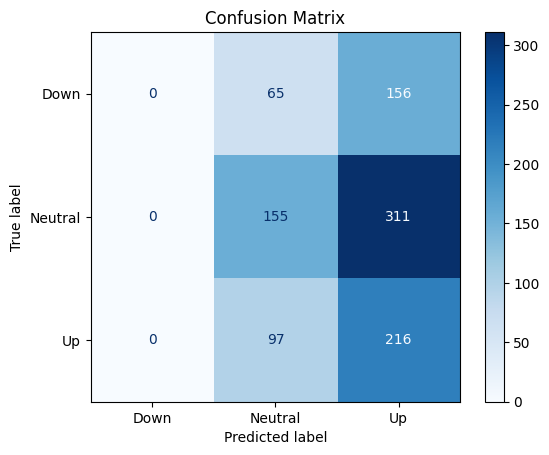

Trainer is attempting to log a value of "[[  0  65 156]
 [  0 155 311]
 [  0  97 216]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [80]:
# Train and evaluate the model
# non_fine_tuned_trainer.train()
non_fine_tuned_eval_result = non_fine_tuned_trainer.evaluate()

In [47]:
# Log metrics
for key, value in non_fine_tuned_eval_result.items():
    print(key, value)

eval_loss 2.6302850246429443
eval_accuracy 0.33
eval_f1 0.24536301006889238
eval_precision 0.2400793650793651
eval_recall 0.32028985507246377
eval_roc_auc 0.46056940358141735
eval_confusion_matrix [[ 0  7 17]
 [ 0 12 34]
 [ 0  9 21]]
eval_runtime 4.7303
eval_samples_per_second 21.14
eval_steps_per_second 2.748


### finetuning the embedding model on labelings to make it impact-aware

In [48]:
class TextDataset(torchDS):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        return {
            'input_ids': torch.tensor(item['input_ids']),
            'attention_mask': torch.tensor(item['attention_mask']),
            'labels': torch.tensor(item['label'])
        }

In [ ]:
def calculate_and_log_metrics(labels, preds, probs, step):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    roc_auc = roc_auc_score(labels, probs, multi_class='ovr')  # Use probabilities here

    # Log the metrics with MLflow
    mlflow.log_metric("accuracy", acc, step=step)
    mlflow.log_metric("f1", f1, step=step)
    mlflow.log_metric("precision", precision, step=step)
    mlflow.log_metric("recall", recall, step=step)
    mlflow.log_metric("roc_auc", roc_auc, step=step)

In [ ]:
fine_tuned_subset = tokenized_train_dataset.select(range(200))

In [49]:
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("ElKulako/cryptobert", num_labels=3)

In [74]:
help(fine_tuned_model)

Help on RobertaForSequenceClassification in module transformers.models.roberta.modeling_roberta object:

class RobertaForSequenceClassification(RobertaPreTrainedModel)
 |  RobertaForSequenceClassification(config)
 |  
 |  RoBERTa Model transformer with a sequence classification/regression head on top (a linear layer on top of the
 |  pooled output) e.g. for GLUE tasks.
 |  
 |  
 |  This model inherits from [`PreTrainedModel`]. Check the superclass documentation for the generic methods the
 |  library implements for all its model (such as downloading or saving, resizing the input embeddings, pruning heads
 |  etc.)
 |  
 |  This model is also a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass.
 |  Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage
 |  and behavior.
 |  
 |  Parameters:
 |      config ([`RobertaConfig`]): Model configuration class with all the parameters of the
 |  

In [50]:
learning_rate = 1e-5
epochs = 5

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Move the model to the device
fine_tuned_model.to(device)
# Set up the optimizer
optimizer = AdamW(fine_tuned_model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(epochs)):  # Number of epochs
    all_labels = []
    all_preds = []
    all_probs = []  # For storing probabilities
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = fine_tuned_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # Store labels, predictions and probabilities for metrics calculation
        preds = torch.nn.functional.softmax(outputs.logits, dim=-1)
        all_probs.append(preds.detach().cpu().numpy())  # Store probabilities
        class_preds = torch.argmax(preds, dim=-1)
        all_preds.append(class_preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    # Calculate and log metrics after each epoch
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)  # Concatenate probabilities

# Evaluation loop
eval_loss = 0
all_labels = []
all_preds = []
all_probs = []  # For storing probabilities
for batch in tqdm(test_dataloader):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = fine_tuned_model(input_ids, attention_mask=attention_mask, labels=labels)
        eval_loss += outputs.loss.item()
        all_labels.append(labels.cpu().numpy())
        # Get the predicted probabilities from the model's outputs
        preds = torch.nn.functional.softmax(outputs.logits, dim=-1)
        all_probs.append(preds.cpu().numpy())  # Store probabilities
        # Convert the probabilities to class labels
        class_preds = torch.argmax(preds, dim=-1)
        all_preds.append(class_preds.cpu().numpy())

# Calculate metrics
all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)
all_probs = np.concatenate(all_probs)  # Concatenate probabilities
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
acc = accuracy_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')  # Use probabilities here


print(f'eval_loss: {eval_loss / len(test_dataloader)}')
print(f'accuracy: {acc}')
print(f'f1: {f1}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'roc_auc: {roc_auc}')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

eval_loss: 0.045429606339894235
accuracy: 1.0
f1: 1.0
precision: 1.0
recall: 1.0
roc_auc: 1.0


huggingface trainer api for the same task

In [51]:
# Define the training arguments
fine_tuned_training_args = TrainingArguments(
    output_dir='../artifact',          # output directory
    num_train_epochs=3.0,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='../log',            # directory for storing logs
)

# Create the Trainer and train
fine_tuned_trainer = Trainer(
    model=fine_tuned_model,                       # the instantiated 🤗 Transformers model to be trained
    args=fine_tuned_training_args,                # training arguments, defined above
    train_dataset=tokenized_train_dataset,    # train dataset
    eval_dataset=tokenized_test_dataset,      # test dataset
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning:

Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)



In [52]:
# Train and evaluate the model
fine_tuned_trainer.train()

Step,Training Loss


TrainOutput(global_step=189, training_loss=1.2360081748356895, metrics={'train_runtime': 148.9326, 'train_samples_per_second': 10.072, 'train_steps_per_second': 1.269, 'total_flos': 394670126592000.0, 'train_loss': 1.2360081748356895, 'epoch': 3.0})

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



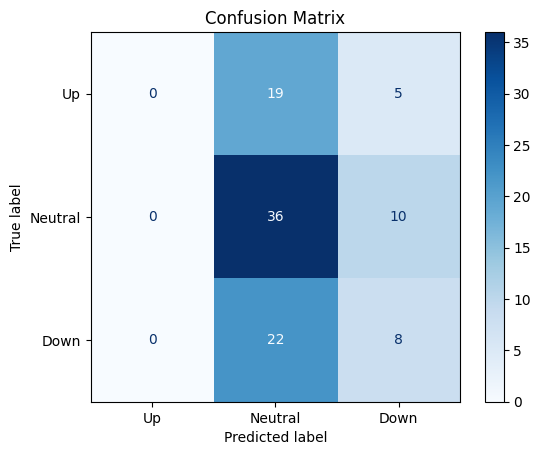

Trainer is attempting to log a value of "[[ 0 19  5]
 [ 0 36 10]
 [ 0 22  8]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [53]:
fine_tuned_eval_result = fine_tuned_trainer.evaluate()

In [54]:
# Log metrics
for key, value in fine_tuned_eval_result.items():
    print(key, value)

eval_loss 1.229904294013977
eval_accuracy 0.44
eval_f1 0.29575088203712224
eval_precision 0.27178618482966305
eval_recall 0.3497584541062802
eval_roc_auc 0.48840208411528013
eval_confusion_matrix [[ 0 19  5]
 [ 0 36 10]
 [ 0 22  8]]
eval_runtime 3.4647
eval_samples_per_second 28.863
eval_steps_per_second 3.752
epoch 3.0
